# 7. Validation

## Maintain modules
Alternative to load code using git repo.

In [55]:
#!git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr

In [56]:
#!git -C cfr2sbvr/ pull

In [57]:
#!ls

### Edit modules

Create module configuration

TODO: Create new notebook


In [58]:
!mkdir configuration && touch configuration/__init__.py

mkdir: cannot create directory ‘configuration’: File exists


In [59]:
%%writefile configuration/main.py

import json
import os
import time
import re
import glob
import yaml
from datetime import datetime

def get_next_filename(file_dir: str, file_prefix: str, extension: str) -> str:
    """
    Generates the next filename in a sequence based on existing files in a directory,
    considering the file extension.

    The filename format is: `{file_prefix}-{YYYY-MM-DD}-{N}.{extension}`,
    where `N` is an incrementing integer for files with the same date.

    Args:
        file_dir (str): The directory where the files are stored.
        file_prefix (str): The prefix used in the filenames.
        extension (str): The file extension (e.g., 'json', 'txt').

    Returns:
        str: The full path to the next filename in the sequence.

    Example:
        next_file = get_next_filename(DEFAULT_CHECKPOINTS_DIR, 'documents', 'json')
        print(next_file)
        # Output might be: ../checkpoints/documents-2024-10-19-5.json
    """
    today_str: str = datetime.today().strftime('%Y-%m-%d')
    path: str = file_dir

    # Ensure the directory exists
    if not os.path.exists(path):
        os.makedirs(path)

    files = os.listdir(path)

    # Create the pattern dynamically using file_prefix and extension
    pattern = re.compile(
        r'^' + re.escape(file_prefix) + r'-(\d{4}-\d{2}-\d{2})-(\d+)\.' + re.escape(extension) + r'$'
    )

    file_info_list = []

    for filename in files:
        match = pattern.match(filename)
        if match:
            date_str: str = match.group(1)
            number: int = int(match.group(2))
            file_info_list.append({'filename': filename, 'date': date_str, 'number': number})

    if file_info_list:
        # Sort by date and number in descending order
        sorted_files = sorted(
            file_info_list,
            key=lambda x: (x['date'], x['number']),
            reverse=True
        )

        latest_file_info = sorted_files[0]
        latest_date: str = latest_file_info['date']
        latest_number: int = latest_file_info['number']

        if latest_date == today_str:
            new_number: int = latest_number + 1
        else:
            new_number = 1
    else:
        new_number = 1

    new_filename: str = f'{file_prefix}-{today_str}-{new_number}.{extension}'
    new_filepath: str = os.path.join(path, new_filename)

    return new_filepath


# Load the YAML config file
def load_config(config_file="/content/drive/MyDrive/cfr2sbvr/config.yaml"):
    try:
        with open(config_file, "r") as file:
            config = yaml.safe_load(file)
    except FileNotFoundError:
        raise FileNotFoundError(f"Configuration file {config_file} not found.")
    except yaml.YAMLError as exc:
        raise ValueError(f"Error parsing YAML file {config_file}: {exc}")

    # Ensure config structure is correct
    if "LLM" not in config or "DEFAULT_CHECKPOINT_DIR" not in config:
        raise ValueError("Required configuration keys are missing in the config file.")

    # Set the OpenAI API key from environment variable if it's not set in config
    config["LLM"]["OPENAI_API_KEY"] = os.getenv(
        "OPENAI_API_KEY", config["LLM"].get("OPENAI_API_KEY")
    )

    # Dynamically set checkpoint and report files using the get_next_filename function
    config["DEFAULT_CHECKPOINT_FILE"] = get_next_filename(
        config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
    )
    config["DEFAULT_EXTRACTION_REPORT_FILE"] = get_next_filename(
        config["DEFAULT_OUTPUT_DIR"], "extraction_report", "html"
    )

    return config

Overwriting configuration/main.py


Mounting Google Drive

In [60]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  # backup on Google Drive
  !cp -r configuration /content/drive/MyDrive/cfr2sbvr/modules

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extract / classify elements

### Imports

In [61]:
import glob
import json
import jellyfish
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

### Configuration

In [62]:
import configuration.main as configuration

# Development mode
import importlib
importlib.reload(configuration)

<module 'configuration.main' from '/content/configuration/main.py'>

Load configuration

In [63]:
config = configuration.load_config()

In [64]:
config

{'LOG_LEVEL': 'INFO',
 'DEFAULT_LOG_DIR': '/content/drive/MyDrive/cfr2sbvr/logs',
 'LLM': {'OPENAI_API_KEY': None,
  'MODEL': 'gpt-4o',
  'EMBEDDING_MODEL': 'text-embedding-3-small',
  'TEMPERATURE': 0,
  'MAX_TOKENS': 4095},
 'ALLEGROGRAPH': {'REPO': 'cfr2sbvr',
  'CATALOG': 'root',
  'HOST': 'ag1eawvuu0p3zv35.allegrograph.cloud',
  'PORT': 443,
  'USER': 'admin',
  'PASSWORD': 'GYL6N1KPB4R4xdWKIZqrYw',
  'HOME_DIR': '/home/adsantos/agraph-8.2.1'},
 'DEFAULT_DATA_DIR': '/content/drive/MyDrive/cfr2sbvr/data',
 'DEFAULT_CHECKPOINT_DIR': '/content/drive/MyDrive/cfr2sbvr/checkpoints',
 'DEFAULT_OUTPUT_DIR': '/content/drive/MyDrive/cfr2sbvr/outputs',
 'DEFAULT_CHECKPOINT_FILE': '/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-25-1.json',
 'DEFAULT_EXTRACTION_REPORT_FILE': '/content/drive/MyDrive/cfr2sbvr/outputs/extraction_report-2024-10-25-1.html',
 'DEFAULT_EXCEL_FILE': '/content/drive/MyDrive/cfr2sbvr/outputs/compare_items_metrics.xlsx',
 'FIBO_GRAPH': 'fibo:FIBO_Graph',
 

### General functions

In [65]:
# Function to group expressions by doc_id
def group_expressions_by_doc_id(expressions_list, is_pred=False):
    doc_id_map = defaultdict(list)
    for item in expressions_list:
        doc_id = item['doc_id']
        if is_pred:
            # Include filename, id, and classification for pred_list items
            expression_info = {
                'id': item['id'],
                'expression': item['expression'],
                'classification_pred': item.get('classification', None),
                'filename_pred': item['filename']
            }
        else:
            # Include id and classification for true_list items
            expression_info = {
                'id': item['id'],
                'expression': item['expression'],
                'classification_true': item.get('classification', None)
            }
        doc_id_map[doc_id].append(expression_info)
    return doc_id_map

# Function to check the similarity between true and pred expressions grouped by doc_id
def check_for_expressions_similarity(true_list, pred_list, threshold=0.7):
    # Build mappings from doc_id to list of expressions
    true_expressions_by_doc_id = group_expressions_by_doc_id(true_list)
    pred_expressions_by_doc_id = group_expressions_by_doc_id(pred_list, is_pred=True)

    results = []
    all_doc_ids = set(true_expressions_by_doc_id.keys()).union(pred_expressions_by_doc_id.keys())

    for doc_id in all_doc_ids:
        true_expressions = true_expressions_by_doc_id.get(doc_id, [])
        pred_expressions = pred_expressions_by_doc_id.get(doc_id, [])

        for pred_item in pred_expressions:
            pred_expr = pred_item['expression']
            pred_id = pred_item['id']
            classification_pred = pred_item.get('classification_pred', None)
            filename_pred = pred_item['filename_pred']
            best_match = None
            best_score = 0
            best_true_id = None
            classification_true = None
            for true_item in true_expressions:
                true_expr = true_item['expression']
                true_id = true_item['id']
                # Calculate the similarity score using the Levenshtein distance
                score = jellyfish.levenshtein_distance(pred_expr, true_expr)
                similarity_score = 1 - (score / max(len(pred_expr), len(true_expr)))  # Normalize to a similarity score

                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = true_expr
                    best_true_id = true_id
                    classification_true = true_item.get('classification_true', None)
            results.append({
                "doc_id": doc_id,
                "pred_id": pred_id,
                "true_id": best_true_id,
                "classification_pred": classification_pred,
                "classification_true": classification_true,
                "filename_pred": filename_pred,
                "pred_expression": pred_expr,
                "true_expression": best_match,
                "similarity_score": best_score
            })
    return results

# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return 'identical'
    elif score >= 0.9:
        return 'close-match'
    else:
        return 'not-sure'

# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == 'identical':
        color = 'green'
    elif val == 'close-match':
        color = 'yellow'
    else:
        color = 'red'
    return f'background-color: {color}'

### Main

Create a prediction list of elements

In [66]:
# Define the path where your JSON files are located
json_files_path = f'{config["DEFAULT_CHECKPOINT_DIR"]}/*.json'

# List of all JSON files in the directory
all_files = glob.glob(json_files_path)

pred_elements = []
# Loop through each file
for file_path in all_files:
    #print(file_path.replace("../checkpoints/", ""))
    with open(file_path, "r") as file:
        # Load JSON content
        try:
            data = json.load(file)
        except json.JSONDecodeError:
            #print(f"Error reading {file_path}, skipping this file.")
            continue
        # Filter keys that end with '_P1|llm_response'
        filtered_data = {
            key: value
            for key, value in data.items()
            if key.endswith("_P1|llm_response")
        }

        for value_list in filtered_data.values():
            #print(value_list["id"])
            for element in value_list["content"]["elements"]:
                pred_elements.append(
                    {"doc_id": value_list["id"], "id": element["id"], "expression": element["expression"], "classification": element["classification"], "filename": file_path.replace("../checkpoints/", "")}
                )
                #print(element["id"], element["expression"])


        # Check if filtered_data is empty
        if not filtered_data:
            #print(f"No matching keys in {file_path}, skipping this file.")
            continue

print(f"Count: {len(pred_elements)}, Elements: {pred_elements}")

Count: 388, Elements: [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'filename': '/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'filename': '/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as descri

In [67]:
print(len(pred_elements), pred_elements)

388 [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'filename': '/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'filename': '/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this sectio

Create a true list of elements

In [68]:
with open(f'{config["DEFAULT_DATA_DIR"]}/p1_true_table.json', "r") as f:
    json_data = json.load(f)
    true_elements = []
    for elements in json_data.values():
        #print(elements["id"])
        for element in elements["content"]["elements"]:
            true_elements.append(
                {"doc_id": elements["id"], "id": element["id"], "expression": element["expression"], "classification": element["classification"]}
            )
            #print(element["id"], element["expression"])

    print(f"Count: {len(true_elements)}, Elements: {true_elements}")

Count: 23, Elements: [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address 

Create a dataframe of true and pred elements

In [69]:
# Use the function with your data
similarity_results = check_for_expressions_similarity(true_elements, pred_elements)

# Build the dataframe
df_results = pd.DataFrame(similarity_results)

df_results['similarity_classification'] = df_results['similarity_score'].apply(classify_similarity)

df_results['id_match'] = df_results['pred_id'] == df_results['true_id']
df_results['id_match_label'] = df_results['id_match'].map({True: 'match', False: 'mismatch'})

# Apply the styling to the similarity_classification column using `map` instead of `applymap`
styled_df = df_results.style.map(highlight_similarity, subset=["similarity_classification"])
styled_df.set_table_attributes('style="width: 100%; border: 1px solid black;"')
styled_df.set_properties(**{'border': '1px solid black'})

# Display the styled dataframe (if in Jupyter Notebook)
# display(styled_df)


,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
0,§ 275.0-7_P1,1,1,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,An investment adviser has assets under management of less than $25 million.,The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that has assets under management of less than $25 million.,0.396825,not-sure,True,match
1,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,An investment adviser did not have total assets of $5 million or more on the last day of the most recent fiscal year.,The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that did not have total assets of $5 million or more on the last day of the most recent fiscal year.,0.506494,not-sure,True,match
2,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"An investment adviser does not control, is not controlled by, and is not under common control with another investment adviser that has assets under management of $25 million or more.","The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that does not control, is not controlled by, and is not under common control with another investment adviser that has assets under management of $25 million or more.",0.614865,not-sure,True,match
3,§ 275.0-7_P1,4,4,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"Control means the power, directly or indirectly, to direct the management or policies of a person, whether through ownership of securities, by contract, or otherwise.","Control means the power, directly or indirectly, to direct the management or policies of a person, whether through ownership of securities, by contract, or otherwise.",1.000000,identical,True,match
4,§ 275.0-7_P1,5,5,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a corporation if the person directly or indirectly has the right to vote 25 percent or more of a class of the corporation's voting securities.,A person is presumed to control a corporation if the person directly or indirectly has the right to vote 25 percent or more of a class of the corporation's voting securities.,1.000000,identical,True,match
5,§ 275.0-7_P1,6,6,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"A person is presumed to control a partnership if the person has the right to receive upon dissolution, or has contributed, 25 percent or more of the capital of the partnership.","A person is presumed to control a partnership if the person has the right to receive upon dissolution, or has contributed, 25 percent or more of the capital of the partnership.",1.000000,identical,True,match
6,§ 275.0-7_P1,7,7,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a limited liability company (LLC) if the person directly or indirectly has the right to vote 25 percent or more of a class of the interests of the LLC.,A person is presumed to control a limited liability company (LLC) if the person directly or indirectly has the right to vote 25 percent or more of a class of the interests of the LLC.,1.000000,identical,True,match
7,§ 275.0-7_P1,8,8,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a trust if the person is a trustee or managing agent of the trust.,A person is presumed to control a trust if the person is a trustee or managing agent of the trust.,1.000000,identical,True,match
8,§ 275.0-7_P1,9,9,Fact Ty

Display the First 10 Rows

In [70]:
# Select the first 10 rows from df_results
df_top10 = df_results.head(10)

# Apply the styling to the sliced DataFrame
styled_df_top10 = df_top10.style.applymap(highlight_similarity, subset=["similarity_classification"])
styled_df_top10.set_table_attributes('style="width: 100%; border: 1px solid black;"')
styled_df_top10.set_properties(**{'border': '1px solid black'})

# Display the styled DataFrame (if in Jupyter Notebook)
display(styled_df_top10)

<ipython-input-70-fe38a7b244c8>:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df_top10 = df_top10.style.applymap(highlight_similarity, subset=["similarity_classification"])


,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
0,§ 275.0-7_P1,1,1,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,An investment adviser has assets under management of less than $25 million.,The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that has assets under management of less than $25 million.,0.396825,not-sure,True,match
1,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,An investment adviser did not have total assets of $5 million or more on the last day of the most recent fiscal year.,The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that did not have total assets of $5 million or more on the last day of the most recent fiscal year.,0.506494,not-sure,True,match
2,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"An investment adviser does not control, is not controlled by, and is not under common control with another investment adviser that has assets under management of $25 million or more.","The term small business or small organization for purposes of the Investment Advisers Act of 1940 shall mean an investment adviser that does not control, is not controlled by, and is not under common control with another investment adviser that has assets under management of $25 million or more.",0.614865,not-sure,True,match
3,§ 275.0-7_P1,4,4,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"Control means the power, directly or indirectly, to direct the management or policies of a person, whether through ownership of securities, by contract, or otherwise.","Control means the power, directly or indirectly, to direct the management or policies of a person, whether through ownership of securities, by contract, or otherwise.",1.000000,identical,True,match
4,§ 275.0-7_P1,5,5,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a corporation if the person directly or indirectly has the right to vote 25 percent or more of a class of the corporation's voting securities.,A person is presumed to control a corporation if the person directly or indirectly has the right to vote 25 percent or more of a class of the corporation's voting securities.,1.000000,identical,True,match
5,§ 275.0-7_P1,6,6,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,"A person is presumed to control a partnership if the person has the right to receive upon dissolution, or has contributed, 25 percent or more of the capital of the partnership.","A person is presumed to control a partnership if the person has the right to receive upon dissolution, or has contributed, 25 percent or more of the capital of the partnership.",1.000000,identical,True,match
6,§ 275.0-7_P1,7,7,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a limited liability company (LLC) if the person directly or indirectly has the right to vote 25 percent or more of a class of the interests of the LLC.,A person is presumed to control a limited liability company (LLC) if the person directly or indirectly has the right to vote 25 percent or more of a class of the interests of the LLC.,1.000000,identical,True,match
7,§ 275.0-7_P1,8,8,Rule,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/documents-2024-10-20-3.json,A person is presumed to control a trust if the person is a trustee or managing agent of the trust.,A person is presumed to control a trust if the person is a trustee or managing agent of the trust.,1.000000,identical,True,match
8,§ 275.0-7_P1,9,9,Fact Ty

Computing the confusion matrix and classification report between classification_true and classification_pred.

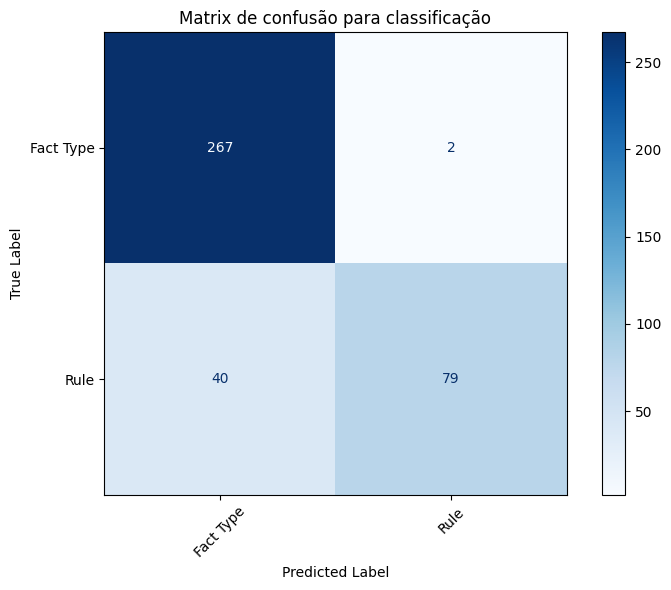

Classification Report:

              precision    recall  f1-score   support

   Fact Type     0.8697    0.9926    0.9271       269
        Rule     0.9753    0.6639    0.7900       119

    accuracy                         0.8918       388
   macro avg     0.9225    0.8282    0.8585       388
weighted avg     0.9021    0.8918    0.8850       388



In [71]:
# Prepare the data
df_evaluation = df_results.dropna(subset=['classification_true', 'classification_pred'])

y_true = df_evaluation['classification_true']
y_pred = df_evaluation['classification_pred']

# Get the unique labels from both y_true and y_pred
labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Matrix de confusão para classificação')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, labels=labels, digits=4)
print("Classification Report:\n")
print(report)

Analyzing the Distribution of Similarity Classifications

Similarity Classification Distribution:
 similarity_classification
identical    368
not-sure      20
Name: count, dtype: int64


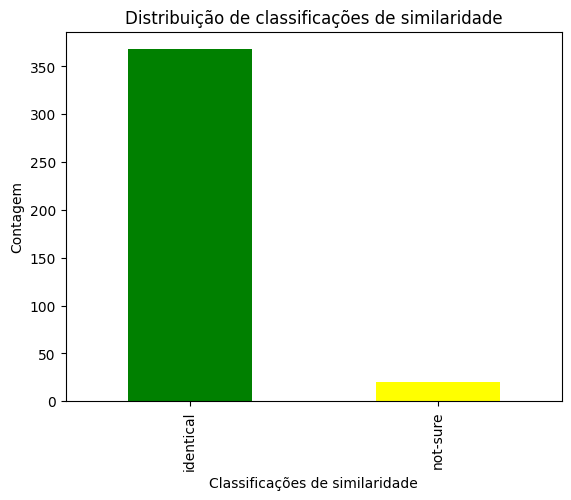

In [72]:
similarity_counts = df_results['similarity_classification'].value_counts()
print("Similarity Classification Distribution:\n", similarity_counts)

# Plotting the distribution
similarity_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribuição de classificações de similaridade')
plt.xlabel('Classificações de similaridade')
plt.ylabel('Contagem')
plt.show()


### Deep analysis of mismatches

Filter the DataFrame to only include rows where similarity_classification is 'not-sure'

In [73]:
df_not_sure = df_results[df_results['similarity_classification'] == 'not-sure']

df_not_sure

,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
0,§ 275.0-7_P1,1,1,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,An investment adviser has assets under managem...,The term small business or small organization ...,0.396825,not-sure,True,match
1,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,An investment adviser did not have total asset...,The term small business or small organization ...,0.506494,not-sure,True,match
2,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,"An investment adviser does not control, is not...",The term small business or small organization ...,0.614865,not-sure,True,match
62,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,Did not have total assets of $5 million or mor...,The term small business or small organization ...,0.406926,not-sure,True,match
63,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,"Does not control, is not controlled by, and is...",The term small business or small organization ...,0.537162,not-sure,True,match
116,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,An investment adviser did not have total asset...,The term small business or small organization ...,0.506494,not-sure,True,match
117,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,"An investment adviser does not control, is not...",The term small business or small organization ...,0.614865,not-sure,True,match
132,§ 275.0-7_P1,1,1,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,An investment adviser has assets under managem...,The term small business or small organization ...,0.396825,not-sure,True,match
133,§ 275.0-7_P1,2,2,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,An investment adviser did not have total asset...,The term small business or small organization ...,0.506494,not-sure,True,match
134,§ 275.0-7_P1,3,3,Fact Type,Fact Type,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,"An investment adviser does not control, is not...",The term small business or small organization ...,0.614865,not-sure,True,match


Filter for 'close-match' entries

In [74]:

df_close_match = df_results[df_results['similarity_classification'] == 'close-match']

df_close_match

,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label


Filter entries where the predicted classification does not match the true classification

In [75]:
df_classification_mismatch = df_results[
    df_results['classification_pred'] != df_results['classification_true']
]

df_classification_mismatch

,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
31,§ 275.0-7_P1,5,5,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a corporation ...,A person is presumed to control a corporation ...,1.0,identical,True,match
32,§ 275.0-7_P1,6,6,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a partnership ...,A person is presumed to control a partnership ...,1.0,identical,True,match
33,§ 275.0-7_P1,7,7,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a limited liab...,A person is presumed to control a limited liab...,1.0,identical,True,match
34,§ 275.0-7_P1,8,8,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a trust if the...,A person is presumed to control a trust if the...,1.0,identical,True,match
39,§ 275.0-7_P1,5,5,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a corporation ...,A person is presumed to control a corporation ...,1.0,identical,True,match
40,§ 275.0-7_P1,6,6,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a partnership ...,A person is presumed to control a partnership ...,1.0,identical,True,match
41,§ 275.0-7_P1,7,7,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a limited liab...,A person is presumed to control a limited liab...,1.0,identical,True,match
42,§ 275.0-7_P1,8,8,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a trust if the...,A person is presumed to control a trust if the...,1.0,identical,True,match
65,§ 275.0-7_P1,5,5,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a corporation ...,A person is presumed to control a corporation ...,1.0,identical,True,match
66,§ 275.0-7_P1,6,6,Fact Type,Rule,/content/drive/MyDrive/cfr2sbvr/checkpoints/do...,A person is presumed to control a partnership ...,A person is presumed to control a partnership ...,1.0,identical,True,match


In [76]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_classification_mismatch)

https://docs.google.com/spreadsheets/d/1cLUw0l1bL7dryIyMvyYpnVE-8SrXrMmyhgwllikrUv4#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [77]:
df_classification_mismatch = df_results[
    df_results['classification_pred'] != df_results['classification_true']
]

# Display the filtered DataFrame
print(df_classification_mismatch)

# Select specific columns to display
columns_to_display = ['doc_id', 'pred_id', 'true_id', 'classification_pred', 'classification_true', 'similarity_score']
df_mismatch_selected = df_classification_mismatch[columns_to_display]

print(df_mismatch_selected)

# Iterate over the mismatches and print details
for index, row in df_classification_mismatch.iterrows():
    print(f"Index: {index}")
    print(f"Doc ID: {row['doc_id']}")
    print(f"Predicted Classification (ID {row['pred_id']}): {row['classification_pred']}")
    print(f"True Classification (ID {row['true_id']}): {row['classification_true']}")
    print(f"Similarity Score: {row['similarity_score']:.4f}")
    print(f"Predicted Expression: {row['pred_expression']}")
    print(f"True Expression: {row['true_expression']}")
    print("-" * 80)

# Get the number of classification mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Calculate mismatch percentage
total_comparisons = len(df_results.dropna(subset=['classification_true', 'classification_pred']))
mismatch_percentage = (num_mismatches / total_comparisons) * 100

print(f"Mismatch Percentage: {mismatch_percentage:.2f}%")

           doc_id  pred_id  true_id classification_pred classification_true  \
31   § 275.0-7_P1        5        5           Fact Type                Rule   
32   § 275.0-7_P1        6        6           Fact Type                Rule   
33   § 275.0-7_P1        7        7           Fact Type                Rule   
34   § 275.0-7_P1        8        8           Fact Type                Rule   
39   § 275.0-7_P1        5        5           Fact Type                Rule   
40   § 275.0-7_P1        6        6           Fact Type                Rule   
41   § 275.0-7_P1        7        7           Fact Type                Rule   
42   § 275.0-7_P1        8        8           Fact Type                Rule   
65   § 275.0-7_P1        5        5           Fact Type                Rule   
66   § 275.0-7_P1        6        6           Fact Type                Rule   
67   § 275.0-7_P1        7        7           Fact Type                Rule   
68   § 275.0-7_P1        8        8           Fact T

Filter entries where the predicted classification does not match the true classification

In [78]:
df_classification_mismatch = df_results[
    df_results['classification_pred'] != df_results['classification_true']
]

# Display the number of mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Display the mismatches
print(df_classification_mismatch)

Number of classification mismatches: 42
           doc_id  pred_id  true_id classification_pred classification_true  \
31   § 275.0-7_P1        5        5           Fact Type                Rule   
32   § 275.0-7_P1        6        6           Fact Type                Rule   
33   § 275.0-7_P1        7        7           Fact Type                Rule   
34   § 275.0-7_P1        8        8           Fact Type                Rule   
39   § 275.0-7_P1        5        5           Fact Type                Rule   
40   § 275.0-7_P1        6        6           Fact Type                Rule   
41   § 275.0-7_P1        7        7           Fact Type                Rule   
42   § 275.0-7_P1        8        8           Fact Type                Rule   
65   § 275.0-7_P1        5        5           Fact Type                Rule   
66   § 275.0-7_P1        6        6           Fact Type                Rule   
67   § 275.0-7_P1        7        7           Fact Type                Rule   
68   § 275.0

### Conclusion

TODO

## References

- [Scikit-LLM: Scikit-Learn Meets Large Language Models](https://medium.com/@sayedebad.777/scikit-llm-scikit-learn-meets-large-language-models-986ff149abcc)
- [23 Game-Changing Python Packages You Are Missing Out On](https://medium.com/pythoneers/23-underrated-python-packages-you-didnt-knew-existed-36dbb0a417c0) - 19 Jellyfish